# Projet Série Temporelles
*AHOUMENOU Onel, DEVIGNAC Vladimir, DURAND Arnaud*

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Introduction

Dans ce projet, nous allons illustrer sur un jeu de données concret les méthodes étudiées au cours. Nos données proviennent du site kaggle https://www.kaggle.com/datasets/aminesnoussi/air-pollution-dataset. Il traite de la pollution de l'air à Pekin.

  L'objectif est donc de prédire la pollution futur à l'aide des données passées en suivant le plan suivant:

1. [Pré-traitement des données](#partie1)
2. [Gestion de la non-stationnarité](#partie2)
3. [Identification de modèle(s) probabiliste(s)](#partie3)
4. [Estimation des paramètres du(des) modèle(s)](#partie4)
5. [Prédiction des valeurs futures](#partie5)
6. [Evaluation de la précision de prédiction](#partie6)

## Pré-traitement des données <a id="partie1"></a>

### Analyse de la base de données

In [2]:
# Importation des données

data = pd.read_csv("air_pollution.csv", index_col='date', parse_dates=True)
data.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


### Isolation de la variable cible "pollution_today"

In [3]:
pollution_today = data['pollution_today']

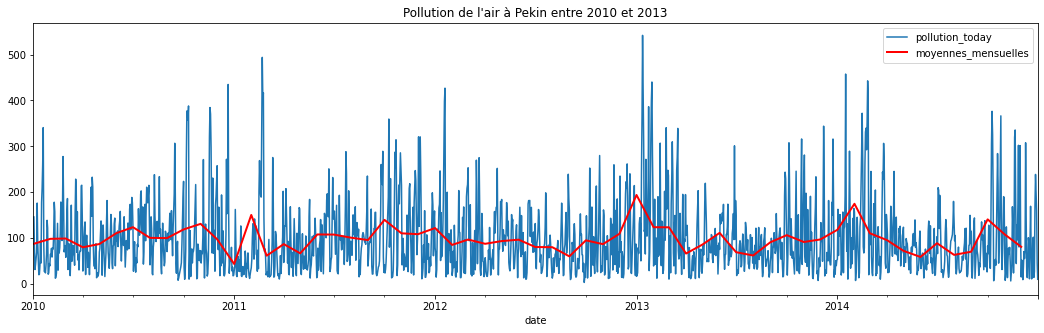

In [4]:
# Affichage de la série temporelle

moyennes_mensuelles = pollution_today.resample('M').mean()

plt.figure(figsize=(18, 5))

pollution_today.plot()
moyennes_mensuelles.plot(label="moyennes_mensuelles", lw=2, c='red')

plt.legend()
plt.title("Pollution de l'air à Pekin entre 2010 et 2013")
plt.show()

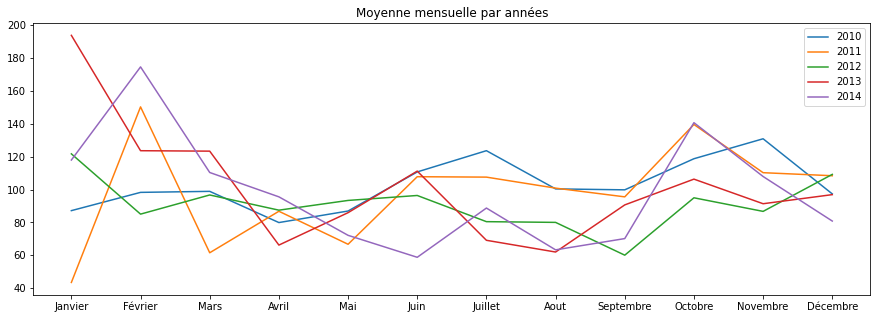

In [5]:
# Moyennes mensuelles par années de la série temporelle

mois = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
années = ['2010', '2011', '2012', '2013', '2014']
sep = 'M'

plt.figure(figsize=(15, 5))
for an in années:
    plt.plot(mois, pollution_today[an].resample(sep).mean(), label=an)
plt.legend()
plt.title("Moyenne mensuelle par années")
plt.show()

In [6]:
# Informations utiles

pollution_today.describe()

count    1825.000000
mean       98.245080
std        76.807697
min         3.166667
25%        42.333333
50%        79.166667
75%       131.166667
max       541.895833
Name: pollution_today, dtype: float64

In [7]:
# Nombre de valeurs manquantes

pollution_today.isna().sum()

0

## Gestion de la non-stationnarité <a id="partie2"></a>

In [8]:
y_train = data['pollution_today']['2010':'2014-11']
y_test = data['pollution_today']['2014-11':]

pollution = y_train

### Isolation de la tendance

Nous allons isoler la tendance à l'aide d'une moyenne mobile d'ordre 7 (pour 7 jours par semaines)

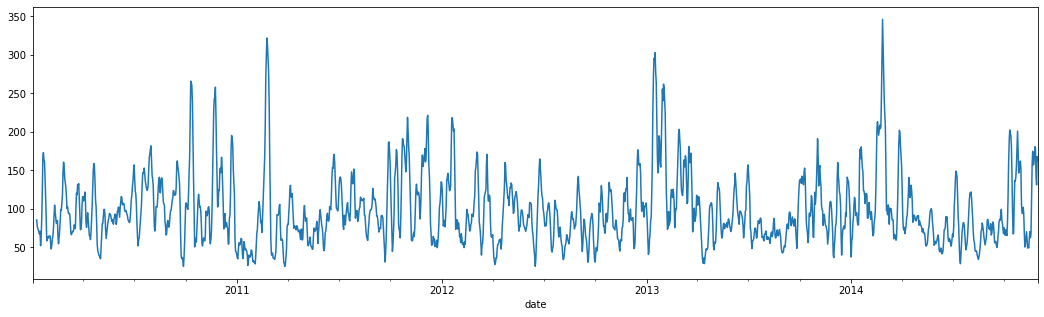

In [9]:
p = 7  # période

tendance_isolee = pollution.rolling(window=p).mean()

plt.figure(figsize=(18, 5))
tendance_isolee.plot()
plt.show()

### Estimation de la saisonnalité

A l'aide de la tendance obtenue précédemment, nous allons determiner la série corrigée de la tendance, notée ici **serie_corrigee_tendance**, puis calculer les coefficients de saisonnalité.

In [10]:
# Saisonnalité

serie_corrigee_tendance = pollution - tendance_isolee
saisonnalite = [np.mean([serie_corrigee_tendance[j] for j in range(p-1, len(pollution)) if j%p == i]) for i in range(p)]

moy = np.mean(saisonnalite)
for i in range(len(saisonnalite)):
    saisonnalite[i] = saisonnalite[i] - moy
sum(saisonnalite)

2.220446049250313e-16

<AxesSubplot:xlabel='date'>

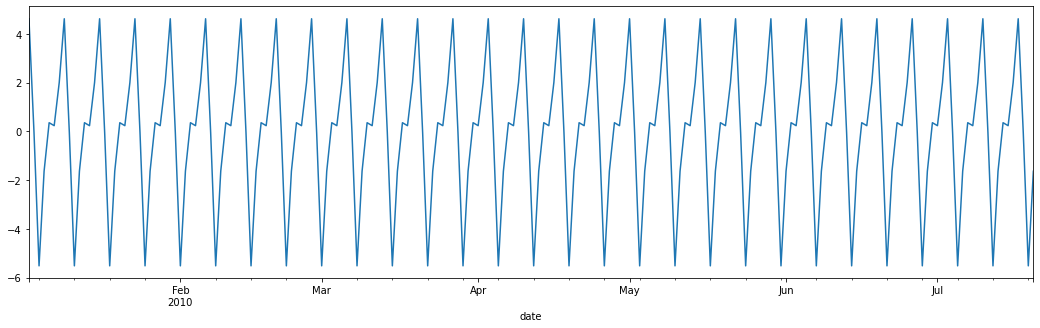

In [11]:
rep_saisonnalite = []

rep_n = 0
while len(rep_saisonnalite) != len(pollution):
    rep_saisonnalite.append(saisonnalite[rep_n%p])
    rep_n += 1

df_saisonnalite = pd.DataFrame(rep_saisonnalite, index = pollution.index, columns=["saisonnalite"])
df_saisonnalite["saisonnalite"][0:200].plot(figsize=(18, 5))

### Estimation de la tendance

<AxesSubplot:xlabel='date'>

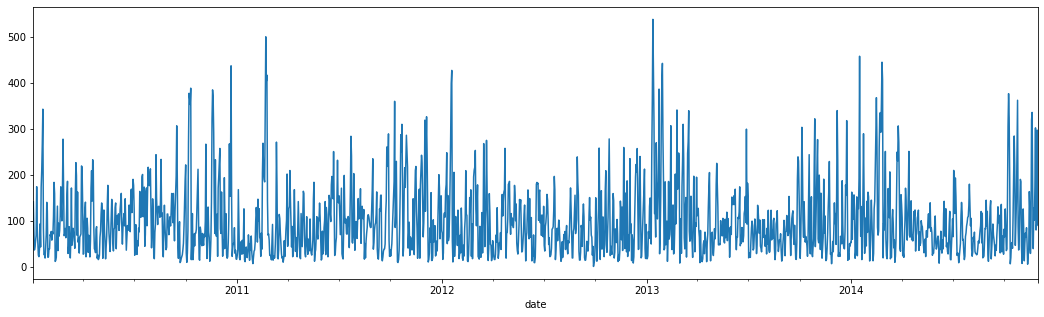

In [12]:
tendance = pollution - rep_saisonnalite

df_tendance = pd.DataFrame(np.array(tendance), index = pollution.index, columns=["tendance"])
df_tendance["tendance"].plot(figsize=(18, 5))